In [57]:
!pip install xgboost

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sb 
  
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC 
from xgboost import XGBClassifier
from sklearn import metrics 
  
import warnings 
warnings.filterwarnings('ignore')

#The dataset I'll use for our analysis and to build a predictive model is Amazon's stock price data. 
#Specifically, I'll utilize the OHLC ('Open', 'High', 'Low', 'Close') data spanning 26 years,
#from May 14, 1997, to March 23, 2023.


df = pd.read_csv('AMZN.csv') 
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [4]:
#This reveals that the dataset contains 6,257 rows of data, with each row comprising 7 distinct columns.
df.shape

(6257, 7)

In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,6257.000000,6257.000000,6257.000000,6257.000000,6257.000000,6.257000e+03
mean,565.005651,571.345671,558.004657,564.817334,564.817334,7.270525e+06
std,918.112233,928.035683,906.961303,917.488221,917.488221,7.108549e+06
min,1.406250,1.447917,1.312500,1.395833,1.395833,4.872000e+05
25%,39.009998,39.799999,38.360001,39.060001,39.060001,3.536500e+06
50%,105.930000,110.625000,101.500000,103.625000,103.625000,5.424200e+06
75%,596.140015,600.750000,588.299988,593.859985,593.859985,8.242900e+06
max,3744.000000,3773.080078,3696.790039,3731.409912,3731.409912,1.043292e+08


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6257 entries, 0 to 6256
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6257 non-null   object 
 1   Open       6257 non-null   float64
 2   High       6257 non-null   float64
 3   Low        6257 non-null   float64
 4   Close      6257 non-null   float64
 5   Adj Close  6257 non-null   float64
 6   Volume     6257 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 342.3+ KB


In [15]:
#This shows no null values in the data
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

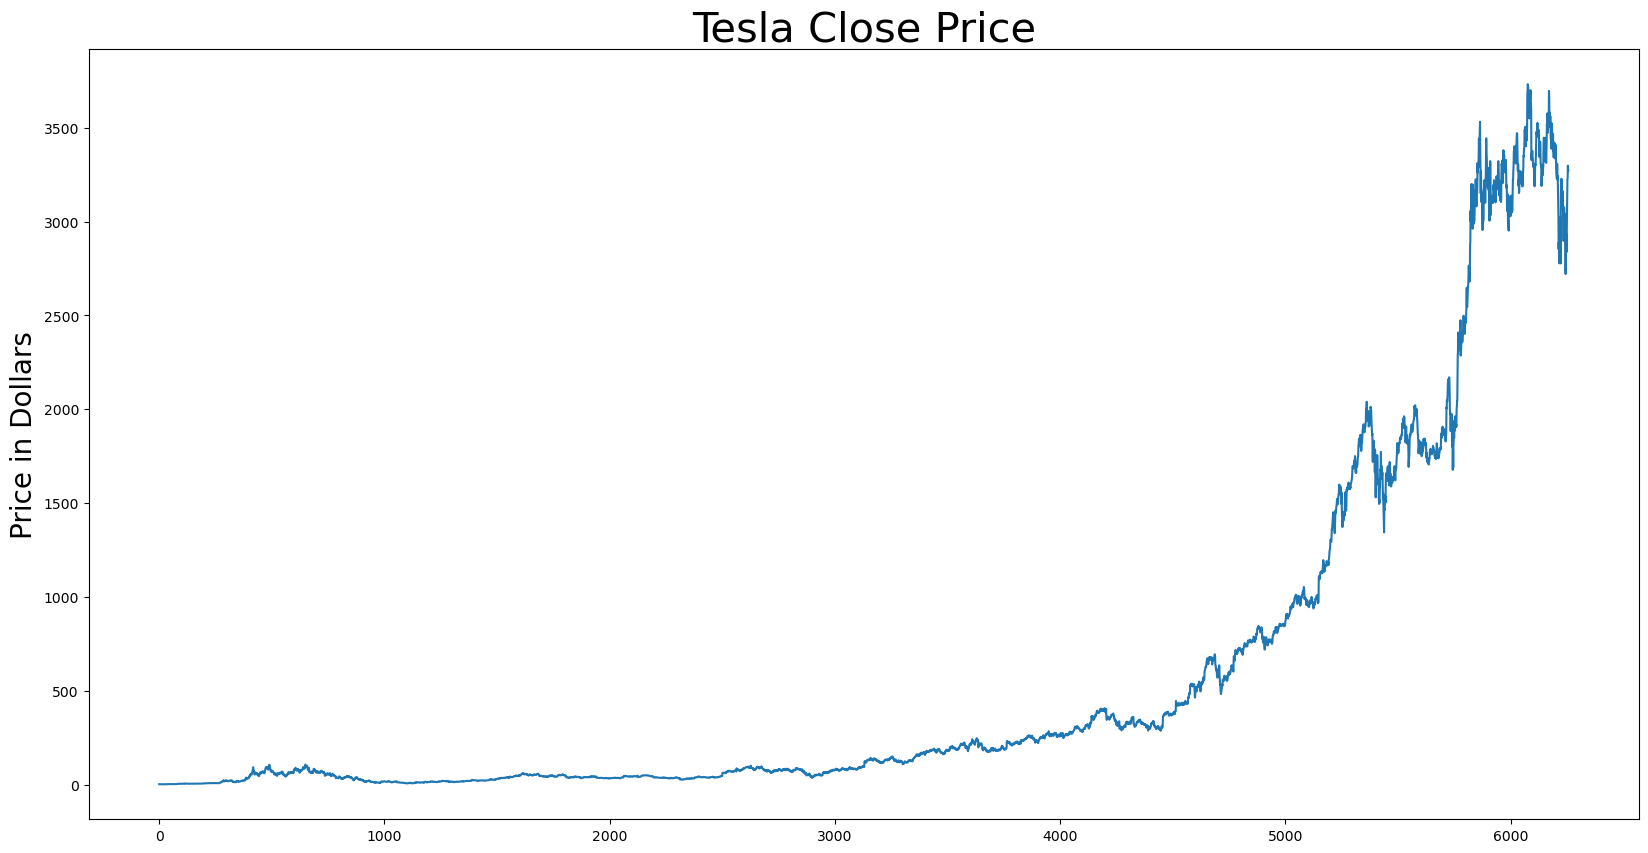

In [16]:
# The plot of Amazon's closing stock prices indicates a consistent upward trend over time.
plt.figure(figsize=(20,10)) 
plt.plot(df['Close']) 
plt.title('Amazon Close Price', fontsize=30) 
plt.ylabel('Price in Dollars', fontsize=20) 
plt.show()

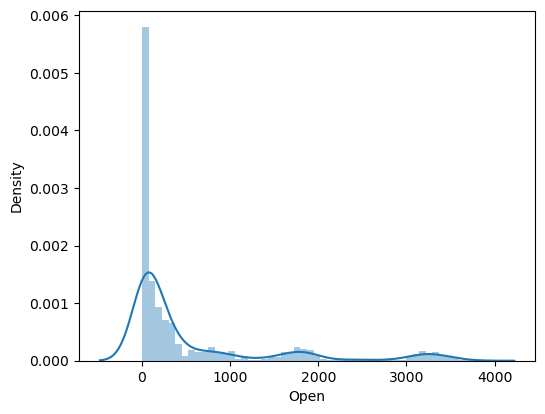

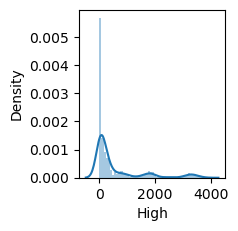

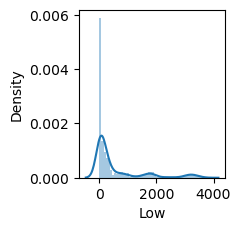

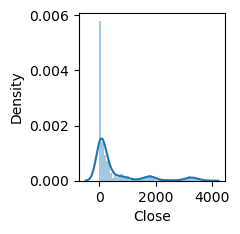

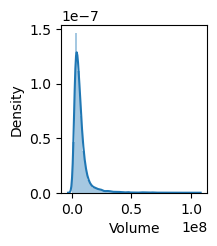

In [22]:
#In the distribution plot of the OHLC data, two distinct peaks are visible, 
#indicating that the data has varied notably across three different ranges. 
#Additionally, the Volume data shows a left-skewed distribution.
features = ['Open', 'High', 'Low', 'Close', 'Volume'] 

plt.subplots(figsize=(20,10)) 

for i, col in enumerate(features): 
    plt.subplot(2,3,i+1) 
    sb.distplot(df[col]) 
    plt.show()

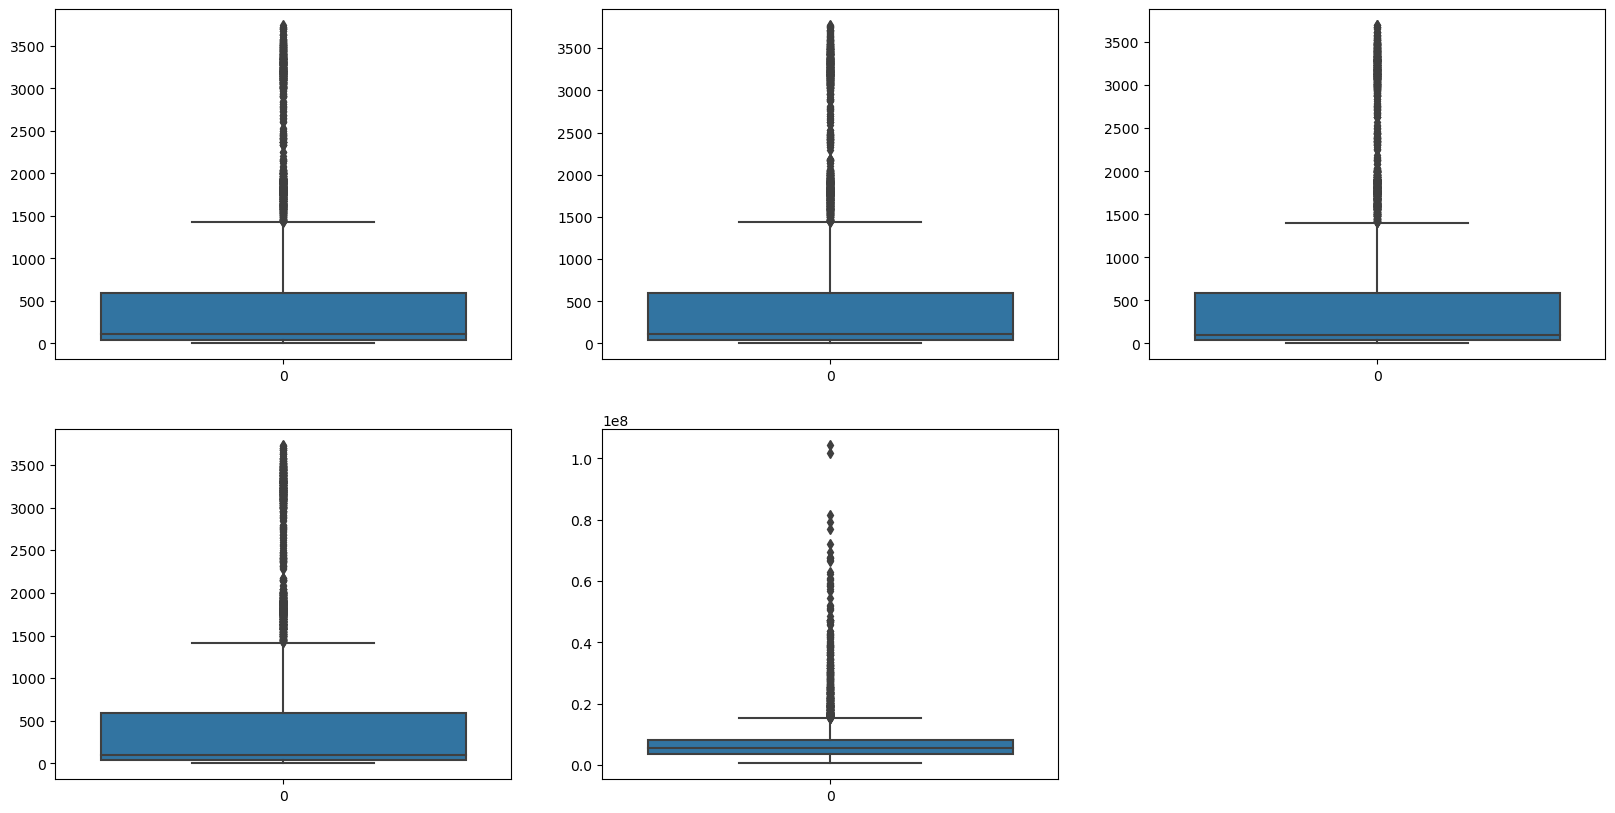

In [23]:
# The boxplots below indicate that outliers are present across all the dataset's columns.
plt.subplots(figsize=(20,10)) 
for i, col in enumerate(features): 
  plt.subplot(2,3,i+1) 
  sb.boxplot(df[col]) 
plt.show()

In [26]:
# I have now added three new columns: ‘month’, ‘year’, and ‘day’, . 
# These columns were extracted from the original ‘Date’ column provided in the dataset.
splitted = df['Date'].str.split('-', expand=True) 

df['month'] = splitted[1].astype('int') 
df['day'] = splitted[2].astype('int') 
df['year'] = splitted[0].astype('int') 

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,month,year,day
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,5,1997,15
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,5,1997,16
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,5,1997,19
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,5,1997,20
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,5,1997,21


In [29]:
#A quarter consists of a three-month period. 
#Companies typically release their quarterly financial results to the public, 
#allowing for analysis of their performance. 
#These quarterly results can significantly impact stock prices, 
#which is why we’ve included this feature in my model, 
#as it could provide valuable insights for the learning algorithm.
df['is_quarter_end'] = np.where(df['month']%3==0,1,0) 
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,month,year,day,is_quarter_end
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,5,1997,15,0
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,5,1997,16,0
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,5,1997,19,0
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,5,1997,20,0
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,5,1997,21,0


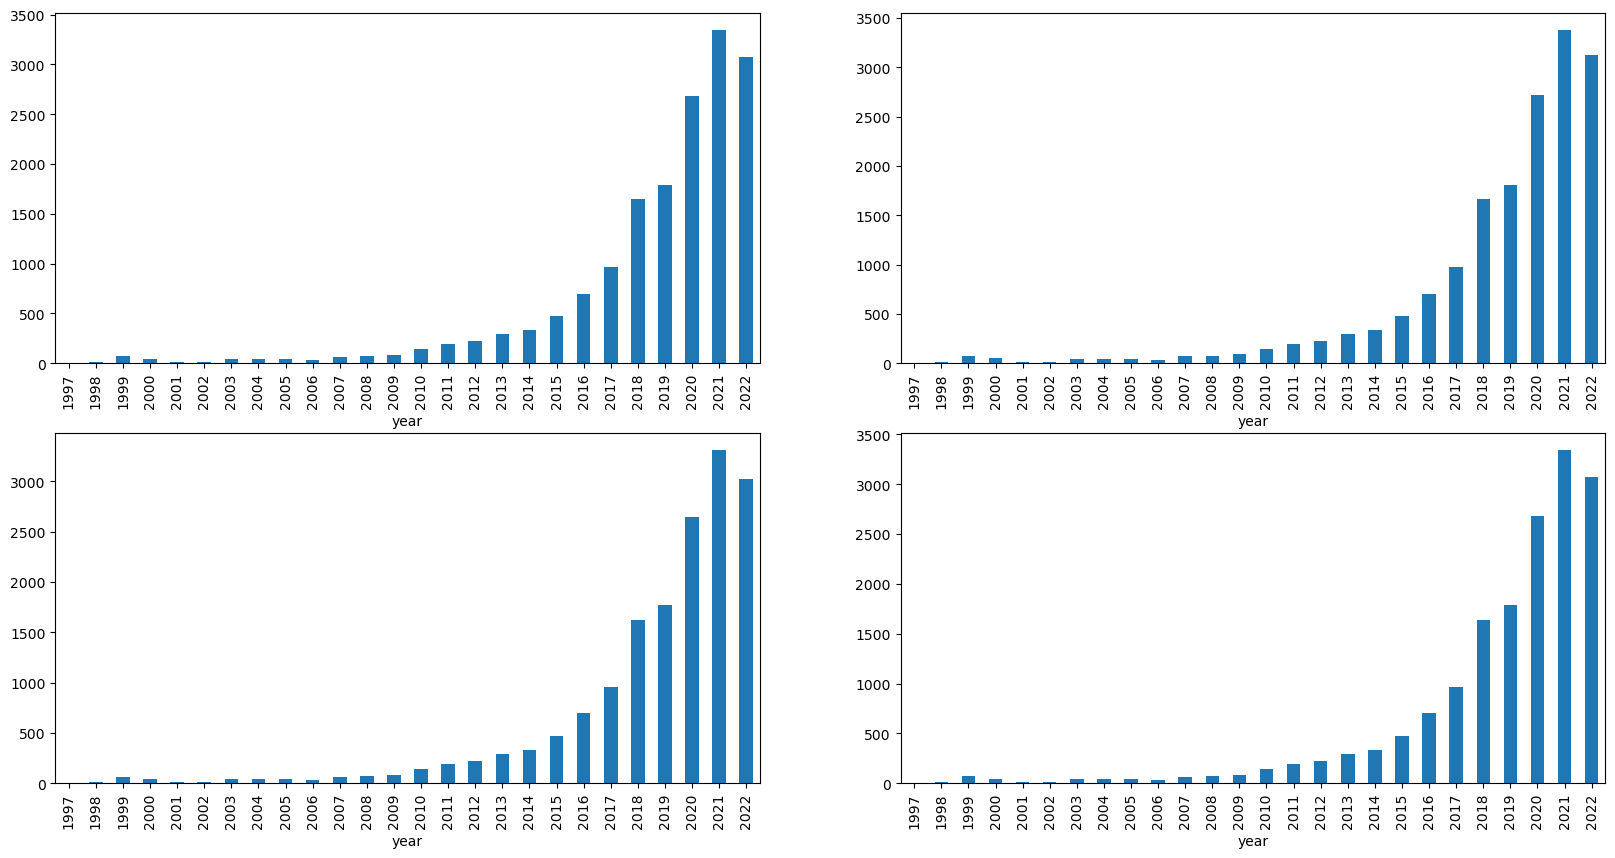

In [30]:
#The bar graph indicates that stock prices have risen exponentially beginning in 2010.
data_grouped = df.groupby('year').mean() 
plt.subplots(figsize=(20,10)) 
  
for i, col in enumerate(['Open', 'High', 'Low', 'Close']): 
  plt.subplot(2,2,i+1) 
  data_grouped[col].plot.bar() 
plt.show()

In [33]:
#This shows trading volume is generally lower in the months that mark the end of a quarter.
#This also shows prices tend to be higher during quarter-end months compared to non-quarter-end months.
#Trading volume is generally lower in the months that mark the end of a quarter
df.groupby('is_quarter_end').mean()

,Open,High,Low,Close,Adj Close,Volume,month,year,day,open-close,low-high,target
is_quarter_end,,,,,,,,,,,,
0,563.401651,569.851395,556.502660,563.345349,563.345349,7.525328e+06,6.106229,2009.331724,15.739739,0.056302,-13.348735,0.512071
1,568.146912,574.272049,560.946157,567.700058,567.700058,6.771520e+06,7.448227,2009.234043,15.721986,0.446854,-13.325892,0.501655


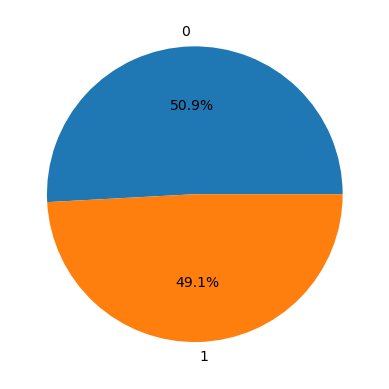

In [32]:
#I've introduced additional columns to assist with training my model. 
#I've added a target feature that indicates whether to buy or not, 
#which will be the focus of our model's predictions. 
#I used a pie chart to determine if the target is balanced.
df['open-close']  = df['Open'] - df['Close'] 
df['low-high']  = df['Low'] - df['High'] 
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

plt.pie(df['target'].value_counts().values,  
        labels=[0, 1], autopct='%1.1f%%') 
plt.show()

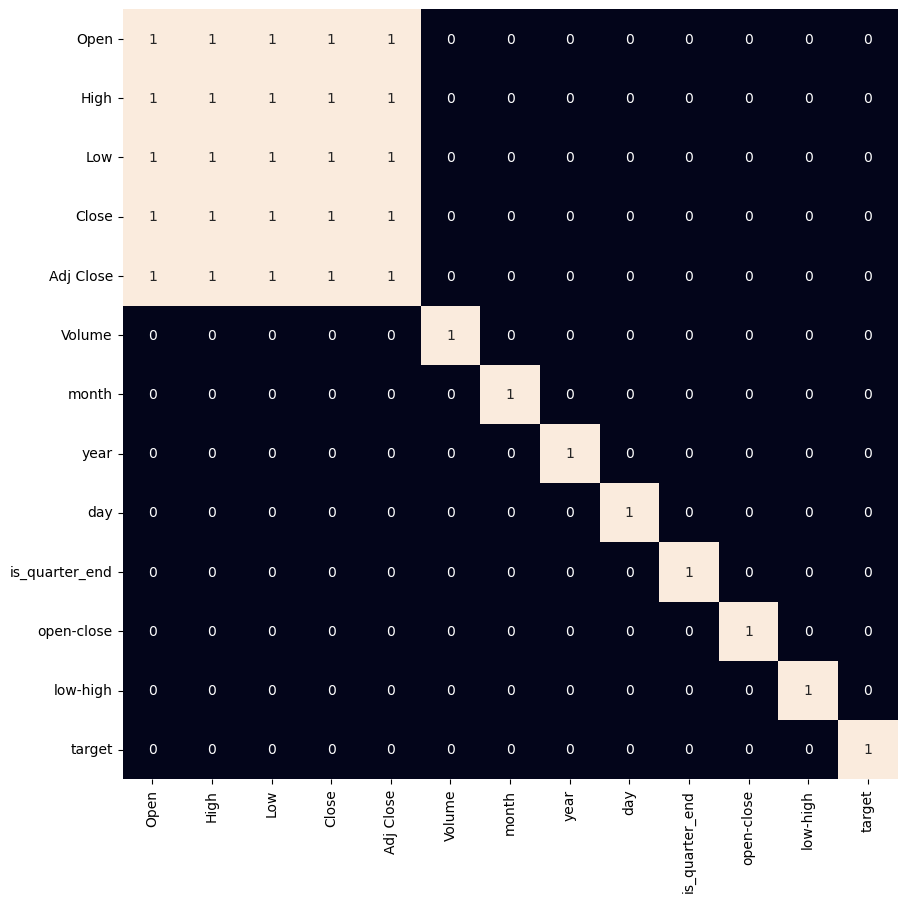

In [34]:
#When adding features to my dataset, I need to make sure there are no highly correlated features, 
#as these can hinder the learning process of the algorithm. 
#From the heatmap, it’s clear that there is a strong correlation among the OHLC features, which is expected. 
#However, the new features I added do not show high correlation with each other or with the existing features, 
#indicating that I’m ready to proceed with building my model.
plt.figure(figsize=(10, 10)) 

sb.heatmap(df.corr() > 0.9, annot=True, cbar=False) 
plt.show() 

In [35]:
#After choosing the features for training my model, 
#I need to normalize the data, as this ensures stable and efficient training. 
#Following normalization, I’ve split the data into two sets using a 9/1 ratio, 
#allowing me to assess the model’s performance on unseen data.
features = df[['open-close', 'low-high', 'is_quarter_end']] 
target = df['target'] 
  
scaler = StandardScaler() 
features = scaler.fit_transform(features) 
  
X_train, X_valid, Y_train, Y_valid = train_test_split( 
    features, target, test_size=0.1, random_state=2022) 
print(X_train.shape, X_valid.shape) 

(5631, 3) (626, 3)


In [41]:
models = [LogisticRegression(), SVC( 
  kernel='poly', probability=True), XGBClassifier()] 
  
for i in range(3): 
  models[i].fit(X_train, Y_train) 
  
  print(f'{models[i]} : ') 
  print('Training Accuracy : ', metrics.roc_auc_score( 
    Y_train, models[i].predict_proba(X_train)[:,1])) 
  print('Validation Accuracy : ', metrics.roc_auc_score( 
    Y_valid, models[i].predict_proba(X_valid)[:,1])) 
  print()

LogisticRegression() : 
Training Accuracy :  0.510737960865857
Validation Accuracy :  0.5480580740014702

SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.5144117245430055
Validation Accuracy :  0.5178571428571428

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training A

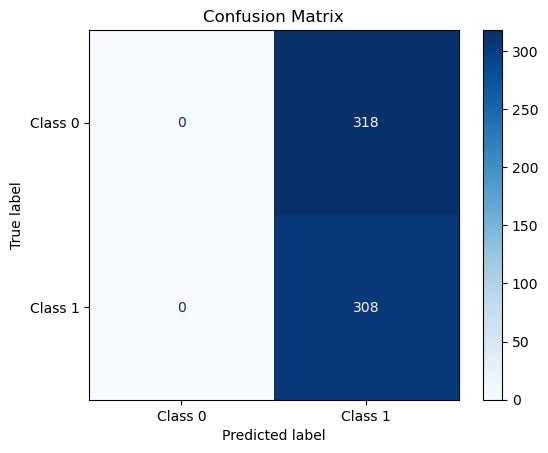

In [65]:
cm = confusion_matrix(Y_valid, models[0].predict(X_valid))

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])

# Plot the confusion matrix
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#Conclusion:
#It appears that the accuracy of the advanced ML model is not significantly better
#than random guessing with a 50% probability. 
#This could be due to factors such as insufficient data 
#or the use of a model that is too basic for the complex task of predicting stock market movements.